In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
## Nome dos paths onse estão salvos e vamos salvar os dados processados
PATH_FAIXA_ETARIAS = '../dados/faixa_etaria/' # Nome do path dos arquivos salvos
PATH_DADOS_PROCESSADOS = '../dados/e_sus_processados/' # Nome do path a salvar os arquivos
PATH_ESTADO = '../dados/municipios/'
PATH_FIGURAS = '../figure/'

FILES_ESTADOS = os.listdir(PATH_DADOS_PROCESSADOS)
FILENAME_FAIXA_ETARIAS = 'faixa_etaria_processada.csv'
FILENAME_ESTADO = 'estados_processada.csv'

dfEstado = pd.read_csv(PATH_ESTADO + FILENAME_ESTADO, encoding='utf-8', delimiter=';')
dfFE = pd.read_csv(PATH_FAIXA_ETARIAS + FILENAME_FAIXA_ETARIAS, encoding='utf-8', delimiter=';')

cols = ['dataNotificacao', 'sexo', 'idade', 'estado_normalizado', 'municipio_normalizado', 'extractDate', 'idadeTrunc']

dflist = []

for file in FILES_ESTADOS:
    dfLoad = pd.read_csv(PATH_DADOS_PROCESSADOS + file, encoding='utf-8', delimiter=';', compression='zip')
    dfLoad = dfLoad[[c for c in dfLoad.columns if c in cols]]
    dflist.append(dfLoad.copy())
    
    print(f'Lido csv {file}')

dfProc = pd.concat(dflist).dropna(how='any',axis=0)

Lido csv rr_sus_processados.csv
Lido csv ba_sus_processados.csv
Lido csv es_sus_processados.csv
Lido csv df_sus_processados.csv
Lido csv rj_sus_processados.csv
Lido csv ma_sus_processados.csv
Lido csv mg_sus_processados.csv
Lido csv sc_sus_processados.csv
Lido csv pe_sus_processados.csv
Lido csv ro_sus_processados.csv
Lido csv pi_sus_processados.csv
Lido csv se_sus_processados.csv
Lido csv go_sus_processados.csv
Lido csv rn_sus_processados.csv
Lido csv pr_sus_processados.csv
Lido csv pa_sus_processados.csv
Lido csv am_sus_processados.csv
Lido csv pb_sus_processados.csv
Lido csv al_sus_processados.csv
Lido csv ac_sus_processados.csv
Lido csv mt_sus_processados.csv
Lido csv ce_sus_processados.csv
Lido csv to_sus_processados.csv
Lido csv sp_sus_processados.csv
Lido csv rs_sus_processados.csv


In [4]:
dfProc.count()

dataNotificacao          5540139
sexo                     5540139
idade                    5540139
estado_normalizado       5540139
municipio_normalizado    5540139
extractDate              5540139
idadeTrunc               5540139
dtype: int64

A base com a populacao dividida em faixa etária é tratada para que numa mesma coluna fiquem o população total, segmentada pelo estado e pela faixa etária a qual pertencem

In [6]:
dfFETab = (dfFE.set_index('idadeTrunc').T
    .reset_index()
    .rename(columns={'index': 'uf'})
    .set_index('uf')
    .stack()
)

dfFETab.name = 'populacao'
dfFETab = dfFETab.reset_index().set_index(['idadeTrunc', 'uf'])
dfFETab

,,populacao
idadeTrunc,uf,
0,AC,167847
10,AC,182031
20,AC,163955
30,AC,136541
40,AC,104798
...,...,...
50,TO,150266
60,TO,95910
70,TO,51374


In [7]:
dfEstado = dfEstado[['codigo_uf', 'uf', 'estado_normalizado']].set_index('estado_normalizado')

In [8]:
dfIdadeEstado = dfProc[['extractDate', 'idadeTrunc', 'estado_normalizado']].copy()

In [7]:
# dfEstado

### Cruzamento dos dados com informações dos estados

O intuito desse cruzamento e a homogenização dos dados com a informação geográfica e nomeclatura dos estados. 

In [9]:
dfIdEst = dfIdadeEstado.join(dfEstado, on = ['estado_normalizado'])
dfIdEst = dfIdEst[(dfIdEst['extractDate'] < '2020-12-31')]

In [10]:
dfIdEst

,extractDate,idadeTrunc,estado_normalizado,codigo_uf,uf
0,2020-07-02,20,roraima,14,RR
1,2020-07-03,40,roraima,14,RR
2,2020-07-01,20,roraima,14,RR
3,2020-06-12,0,roraima,14,RR
4,2020-07-03,40,roraima,14,RR
...,...,...,...,...,...
330925,2020-11-09,30,rio grande do sul,43,RS
330926,2020-11-07,30,rio grande do sul,43,RS
330927,2020-09-15,40,rio grande do sul,43,RS
330928,2020-11-09,40,rio grande do sul,43,RS


Agrupamento dos casos de Covid-19 por estado e faixa estária

In [11]:
################################
# Agrupamento por Idade e Estado
################################

dfGroupIdEst = (dfIdEst[['idadeTrunc', 'extractDate', 'uf']]
         .groupby(['idadeTrunc', 'uf']).agg('count')
         .reset_index()
         .rename(columns={'extractDate': 'soma_casos_covid'})
         .set_index(['idadeTrunc', 'uf'])
        )

################################
# Normalização do total de casos com a população do usuário
################################

dfFinalIdEst = dfGroupIdEst.join(dfFETab, on = ['idadeTrunc', 'uf'])
dfFinalIdEst['norm'] = dfFinalIdEst['soma_casos_covid'].div(dfFinalIdEst['populacao'])
dfFinalIdEst['norm_x1000Hab'] = dfFinalIdEst['soma_casos_covid'].div(dfFinalIdEst['populacao'])*1000
dfFinalIdEst.dropna(how='any',axis=0)

soma_casos_covid  populacao      norm  norm_x1000Hab
idadeTrunc uf                                                      
0          AC               939   167847.0  0.005594       5.594381
           AL              2352   512924.0  0.004585       4.585475
           AM              6960   810784.0  0.008584       8.584284
           BA             14894  2057896.0  0.007237       7.237489
           CE             10089  1300206.0  0.007760       7.759540
...                         ...        ...       ...            ...
90         RJ              1273    91599.0  0.013898      13.897532
           RN               299    14525.0  0.020585      20.585198
           RS               671    61998.0  0.010823      10.822930
           SP              1918   205952.0  0.009313       9.312850
           TO                74     3478.0  0.021277      21.276596

[252 rows x 4 columns]

Probabilidade de ter COVID pertencendo a certa Faixa Etária

In [11]:
# dfProb = dfProc.groupby('idadeTrunc')
# dfProb = (dfProc[['idadeTrunc', 'extractDate']].groupby('idadeTrunc').agg('count')
#           .reset_index().rename(columns={'extractDate': 'soma'}))

# dfProb['Probabilidade_covid_and_idade'] = dfProb['soma'].div(dfProb['soma'].sum())
# dfProb['idadeTrunc'] = dfProb['idadeTrunc'].astype(int)
# dfProb = dfProb.set_index('idadeTrunc')

In [12]:
# dfFESum = dfFE[['idadeTrunc', 'SP']].copy()
# dfSum['idadeTrunc'] = dfSum['idadeTrunc'].astype(int)
# dfSum['Probabilidade_idade'] = (dfSum['SP'] / dfSum['SP'].sum())
# dfSum = dfSum.set_index('idadeTrunc')

In [13]:
# dfFinal = dfProb.join(dfSum, on=['idadeTrunc'], rsuffix = '_sum', how='outer')
# dfFinal['Probabilidade_covid_dada_idade'] = dfFinal['Probabilidade_covid_and_idade'].div(dfFinal['Probabilidade_idade'])
# dfFinal['norm'] = dfFinal['soma'].div(dfFinal['SP'])
# dfFinal['norm_x1000Hab'] = dfFinal['soma'].div(dfFinal['SP'])*1000
# dfFinal

In [14]:
# dfTeste = dfFinal[['Probabilidade_idade']]
# dfTeste.plot(kind='bar', stacked=True, rot=0)

In [21]:
################################
# Agrupamento por Idade, Data do caso e estado
################################

fator_norm = 1000000
col_norm = 'norm_x' + str(fator_norm) +'Hab'


dfGroupIdEstData = (dfIdEst[['idadeTrunc', 'extractDate', 'uf']]
         .groupby(['idadeTrunc', 'extractDate', 'uf']).size()
         .reset_index(name='soma_casos_covid')
         .set_index(['idadeTrunc', 'uf'])
        )

dfGroupIdEstData
################################
# Normalização do total de casos com a população do usuário
################################

dfFinalIdEstData = dfGroupIdEstData.join(dfFETab, on = ['idadeTrunc', 'uf'])
dfFinalIdEstData['norm'] = dfFinalIdEstData['soma_casos_covid'].div(dfFinalIdEstData['populacao'])
dfFinalIdEstData[col_norm] = dfFinalIdEstData['soma_casos_covid'].div(dfFinalIdEstData['populacao'])*fator_norm
dfFinalIdEstData = dfFinalIdEstData.dropna(how='any',axis=0)
dfFinalIdEstData = dfFinalIdEstData[(dfFinalIdEstData[col_norm] < 0.05*fator_norm)]
dfFinalIdEstData = dfFinalIdEstData.reset_index()
dfFinalIdEstData['idadeTrunc'] = dfFinalIdEstData['idadeTrunc'].astype(str)
dfFinalIdEstData = dfFinalIdEstData.set_index(['idadeTrunc', 'uf'])

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


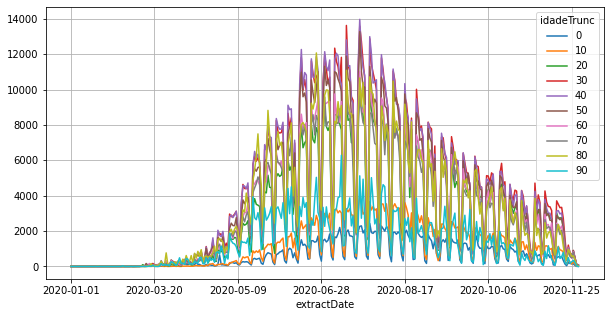

In [75]:
dffinal = pd.pivot_table(dfFinalIdEstData, values=col_norm, index=['extractDate'],
                    columns=['idadeTrunc'], aggfunc=np.sum, fill_value=0)
dffinal.plot(kind='line',figsize=(10,5))
plt.grid()
plt.savefig(f'{PATH_FIGURAS}faixa_etária.png', bbox_inches = 'tight', pad_inches = 0)

In [72]:
##########################
#### Graficando pela meia móvel
##########################
dffinal = pd.pivot_table(dfFinalIdEstData, values=col_norm, index=['extractDate'],
                    columns=['idadeTrunc'], aggfunc=np.sum, fill_value=0)

columns = dffinal.columns.values
mov_avg_columns = []
over_columns = []
under_columns = []


n_step = 50
for col in columns:
    dffinal[f'{col}_mov_avg'] = dffinal[col].rolling(window=n_step).mean()
    dffinal[f'{col}_std'] = dffinal[col].rolling(window=n_step).std()
    dffinal[f'{col}_under'] = dffinal[f'{col}_mov_avg'] - 1.96 * dffinal[f'{col}_std'] / np.sqrt(n_step)
    dffinal[f'{col}_over'] = dffinal[f'{col}_mov_avg'] + 1.96 * dffinal[f'{col}_std'] / np.sqrt(n_step)
    mov_avg_columns.append(f'{col}_mov_avg')
    over_columns.append(f'{col}_over')
    under_columns.append(f'{col}_under')
    
    
dffinal

idadeTrunc,0,10,20,30,40,50,60,70,80,90,...,70_under,70_over,80_mov_avg,80_std,80_under,80_over,90_mov_avg,90_std,90_under,90_over
extractDate,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.180606,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,0.000000,0.000000,0.000000,0.000000,3.174613,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,0.000000,0.000000,0.000000,7.323808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,0.000000,0.000000,0.000000,1.406332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.629649,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25,153.138910,138.619572,504.116514,581.561243,603.213473,561.039355,464.294215,486.515593,574.472829,258.298379,...,1595.788832,2185.537964,1950.999780,1215.778607,1614.003143,2287.996416,681.682858,505.889205,541.457524,821.908191
2020-11-26,146.521068,270.456386,604.010952,904.647700,874.940346,898.697412,833.188105,804.210763,595.395848,347.181614,...,1548.114575,2132.579421,1882.825321,1193.671578,1551.956440,2213.694202,651.564688,478.829598,518.839895,784.289481
2020-11-27,58.394607,126.852037,387.219329,507.730527,468.660795,471.819292,370.400564,326.591238,393.823765,224.391338,...,1485.687298,2065.221921,1801.120321,1151.401757,1481.968037,2120.272605,632.015473,475.848623,500.116964,763.913982


In [71]:
np.sqrt(50)

7.0710678118654755

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


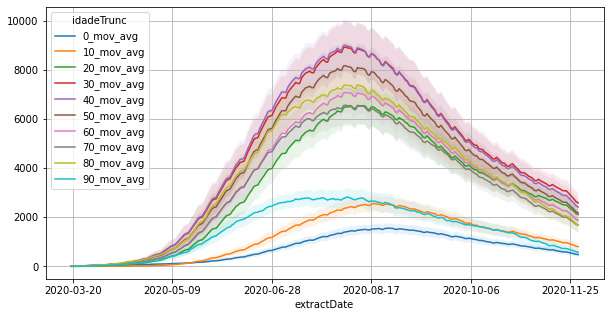

In [74]:
dffinal.plot(kind='line', y= mov_avg_columns, figsize=(10,5))
for under, over in zip(under_columns, over_columns):
    plt.fill_between(dffinal.reset_index()['extractDate'], dffinal[under], dffinal[over], alpha=.1)
plt.grid()
plt.savefig(f'{PATH_FIGURAS}faixa_etária_mov_avg.png', bbox_inches = 'tight', pad_inches = 0)

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


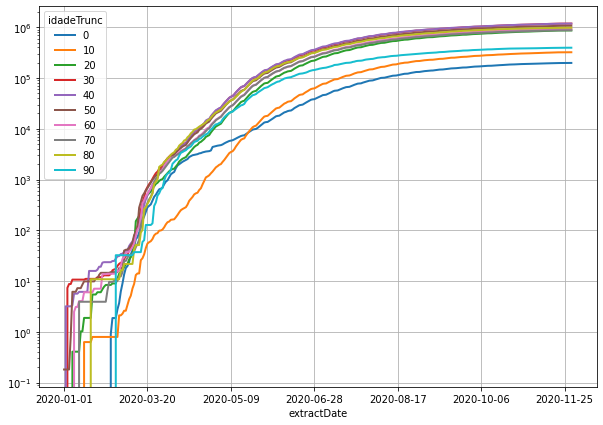

In [91]:
dffinal_acu = dffinal.sort_values(by = ['extractDate'])
dffinal_acu.cumsum().plot(logy = True,figsize=(10,7), linewidth=2)
plt.grid()
plt.savefig(f'{PATH_FIGURAS}faixa_etária_log.png')

/home/german.salazar/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


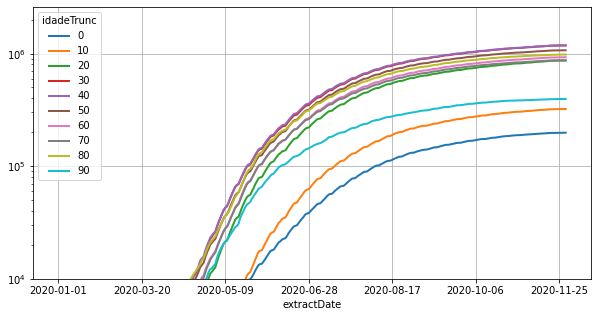

In [89]:
dffinal_acu.cumsum().plot(logy = True,figsize=(10,5), linewidth=2)
plt.grid()
plt.ylim(10000)
plt.savefig(f'{PATH_FIGURAS}faixa_etária_log_zoom.png')

In [20]:
dfFinalIdEstData[(dfFinalIdEstData['norm_x1000000Hab'] < 20000.0)]

extractDate  soma_casos_covid  populacao          norm  \
idadeTrunc uf                                                          
0          RJ  2020-02-27                 2  2224713.0  8.989924e-07   
           GO  2020-02-28                 1  1034767.0  9.664011e-07   
           RJ  2020-03-02                 2  2224713.0  8.989924e-07   
           RJ  2020-03-03                 2  2224713.0  8.989924e-07   
           MG  2020-03-04                 2  2650603.0  7.545453e-07   
...                   ...               ...        ...           ...   
90         PE  2020-11-26                 2    30992.0  6.453278e-05   
           PI  2020-11-26                 1     8913.0  1.121957e-04   
           PR  2020-11-26                 7    41067.0  1.704532e-04   
           PI  2020-11-27                 2     8913.0  2.243913e-04   
           PR  2020-11-28                 1    41067.0  2.435045e-05   

               norm_x1000000Hab  
idadeTrunc uf                    
0          RJ          0.898992  
           GO          0.966401  
           RJ          0.898992  
           RJ          0.898992  
           MG          0.754545  
...                         ...  
90         PE         64.532783  
           PI        112.195669  
           PR        170.453162  
           PI        224.391338  
           PR         24.350452  

[51513 rows x 5 columns]

Classificação por casos de Covid e Faixa etária 

Eixo Y Numero Total de casos normalizados, 
Eixo X Densidade Populacional
Pontinho classificador pela cor -> Casos de Covid por faixa

===============================================================

Modelo regresional

Densidade populacional eixo X
Numero de casos Y

Segmentação por Idade. mostrar um gráfico por idade